In [1]:
import cv2
import matplotlib.pyplot as plt
from copy import copy
import pandas as pd
import os
import face_recognition

# В чем вообще идея:

### Если я пройдусь по всем файлам из директории frames_2012, я смогу создать датафрейм с колонками "название файла", "количество лиц", "процент, который занимают лица на картинке". В дальнейшем можно было бы построить гистограмму распределения, посмотреть, что превалирует (распределение количества лиц, распредение процентажа) + построить график того, в каких моментах фильма процентаж от одного лица наиболее высокий -> так я могла бы находить на протяжении фильма крупные планы (например). В целом это могло бы быть актуально в случае попытки находить крупные планы не только людей, но и вещей, в таком случае мы видели бы, как толстовская детальность передается в фильме.


In [2]:
def classificator(name):
    cascade = cv2.CascadeClassifier(name)
    return cascade

def detect_faces(cascade, image, scaleFactor = 1.1, return_faces=False): 
    '''
    :scaleFactor: то, во сколько раз мы уменьшаем наше окно поиска лиц или чего-либо еще при каждой итерации
    '''
    
    '''на всякий случай поработаем с копией'''
    image_copy = image.copy()

    '''копию картинки переводим в серый, потому что detectMultiScale
       берет на фход только серые изображения'''
    gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)

    '''Детектим лица с помощью haar classifier''' 
    faces = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)
    
#     print("Лиц обнаружено: " + format(len(faces)))

    for (x, y, w, h) in faces:
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 3)

    return (image_copy, faces) if return_faces else image_copy

def compute_face_areas_with_percents(array_of_faces, image, round_digits=1):
    '''This function computes rectangle area and the percentage of it.
    It does not work without function detect_faces, which provides the array of faces (coordinates)'''
    
    img_h, img_w = image.shape[:2] #we do not need rgb size
    img_area = img_h * img_w
    areas = []
    percentages_of_area = []
    for face in array_of_faces:
        w, h = face[2], face[3]
        area = w * h
        percent = area / img_area * 100
        percentages_of_area.append(round(percent, round_digits))
        areas.append(area)
    return areas, percentages_of_area

In [3]:
frontal_face_cascade = classificator('../haarcascade_frontalface_default.xml')
profile_face_cascade = classificator('../haarcascade_profileface.xml')

## Создадим функцию, которая раскладывает наше видео на кадры

In [4]:
def frame_extraction(film_path):
    vidcap = cv2.VideoCapture(film_path)
    success,image = vidcap.read()
    count = 0
    while success:
        cv2.imwrite("frames_2012/{}_frame.jpg".format(count), image)
        success,image = vidcap.read()
#         print('Read a new frame: ', success, ' ', count) #это вероятно можно убрать
        count += 1

In [33]:
def extract_every_k_second_frame(path_to_video, path_to_folder, k: int, start_frame_index=0, 
                                 num_frames_per_sec=24):
    '''Функция отвечает за вычленение первого кадра каждой n-ной секунды (кадров т.о. становится меньше, 
    k - это номер секунды).
    Проблема: есть все-таки монтажные черные склейки, и n-ные секунды могут выпадать на них, из-за чего кадры
    могут получаться не очень качественными. Возможно, этого не будет заметно, или же количество черных кадров
    будет минимальным'''
    
    vidcap = cv2.VideoCapture(path_to_video)
    success,image = vidcap.read()
    count = start_frame_index * num_frames_per_sec * k
    while success:
        success,image = vidcap.read()
    #     print('Read a new frame: ', success, ' ', count) #это вероятно можно убрать
        if count % (num_frames_per_sec * k) == 0:
            cv2.imwrite(path_to_folder + "/{}_frame.jpg".format(count // (num_frames_per_sec * k)), image)  
        count += 1
    return print('done')

## Anna Karenina 2012

In [6]:
film_path = '/Users/tonleon/Desktop/Films/Anna_Karenina_2012.mkv'

In [7]:
extract_every_k_second_frame(film_path,'2012_frames', 1)

done


## Теперь к каждому кадру применим наши функции из скрипта Karenina_OpenCV_practice (которые пока что записаны выше). Результат запишем в датафрейм.

In [43]:
def create_df_with_frames_info(directory, scale_factor=1.2,
                               frontal_face_cascade=frontal_face_cascade, 
                               profile_face_cascade=profile_face_cascade):
    
    columns_name = ['frame_num', 'num_of_faces', 'profile_faces', 'frontal_faces', 'frontal_percentage', 'profile_percentage']
    data = pd.DataFrame(columns = columns_name)
    
    for file in os.listdir(directory):
        if file.endswith('.jpg'):
            image = cv2.imread(os.path.join(directory, file)) #читаем файл, получаем матрицу
            _, frontal_faces = detect_faces(frontal_face_cascade, image, scale_factor, True) #находим лица на картинке, 
                                                                                #получаем координаты картинки и координаты лиц
            
            _, profile_faces = detect_faces(profile_face_cascade, image, scale_factor, True)
            
            frontal_faces_areas,  frontal_percentage = compute_face_areas_with_percents(frontal_faces, image)
            profile_faces_areas,  profile_percentage = compute_face_areas_with_percents(profile_faces, image)
            #подсчитываем площадь (пиксели в кв) и процент от картинки

            dict_of_frames = {'frame_num': file, 'num_of_faces':len(profile_faces)+len(frontal_faces),
                              'profile_faces': profile_faces, 'frontal_faces': frontal_faces, 
                              'frontal_percentage': frontal_percentage, 'profile_percentage': profile_percentage}

            data = data.append(dict_of_frames, ignore_index=True)
    return data

In [21]:
data_2012 = create_df_with_frames_info('2012_frames')

In [22]:
data_2012.to_csv('/Users/tonleon/Documents/GitHub/Diploma/Films/Data/All_Frames_2012.csv', header=True)

In [23]:
'''Возникшие проблемы: 
1) надо понять, как это нормально отсортировать, вероятно, упорядочивать надо еще на этапе обхода директории (странно, что он рандомно
   файлы располагает, а не по порядку, как они лежат у меня в папочке)
2) Надо улучшить df, потому что пока что наличие списка в значении процентажа не совсем правильно и не очень красиво
3) проблема с детектингом - все-таки эта программа совершает значительные ошибки в распознавании лиц
4) надо обрезать черные рамки сверху и снизу кадра
5) надо придумать, что делать с черными кадрами, потому что если их несколько, то скорее всего это склейка, и тогда эту информацию 
можно как-то использовать, но пока что эти кадры просто занимаю место в df'''

# data_2012.sort_index(ascending=True)
data_2012

,frame_num,num_of_faces,percentage
0,frame_3284.jpg,1,[16.77327011674196]
1,frame_1493.jpg,1,[0.787411847147053]
2,frame_5193.jpg,1,[15.99964962502423]
3,frame_2824.jpg,1,[3.005956374588123]
4,frame_5187.jpg,1,[0.9132113730226179]
...,...,...,...
7760,frame_4294.jpg,0,[]
7761,frame_6483.jpg,1,[2.912026061934368]
7762,frame_973.jpg,0,[]
7763,frame_2183.jpg,0,[]


### Посмотрим на кадры, где только одно лица было зафиксировано:

In [24]:
def one_face_frames(data):
    one = data.loc[data['num_of_faces'] == 1]
    pd.set_option('display.max_rows', None)
    return one.sort_values(by = 'percentage')

In [25]:
df_one_face_2012 = one_face_frames(data_2012)

In [28]:
df_one_face_2012.sort_index(ascending=True)

,frame_num,num_of_faces,percentage,actor
0,frame_3284.jpg,1,[16.77327011674196],None
1,frame_1493.jpg,1,[0.787411847147053],None
2,frame_5193.jpg,1,[15.99964962502423],None
3,frame_2824.jpg,1,[3.005956374588123],None
4,frame_5187.jpg,1,[0.9132113730226179],None
5,frame_2830.jpg,1,[5.197663669842406],None
8,frame_3290.jpg,1,[15.244293360766948],None
9,frame_5839.jpg,1,[3.1013776445855883],None
10,frame_5811.jpg,1,[4.771063499873269],None
11,frame_2818.jpg,1,[7.6046279315948775],None


In [27]:
df_one_face_2012['actor'] = None

In [29]:
df_one_face_2012['percentage'] = df_one_face_2012['percentage'].apply(lambda x: round(x[0], 1))

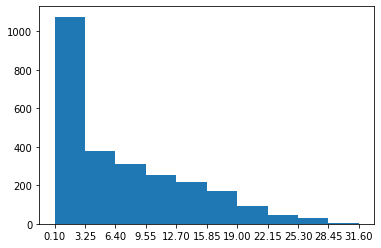

In [30]:
n, bins, _ = plt.hist(df_one_face_2012['percentage'], bins=10)
plt.xticks(bins)
plt.show()

In [31]:
known_image = face_recognition.load_image_file("/Users/tonleon/Desktop/4184.jpg")
keira_encoding = face_recognition.face_encodings(known_image)[0]
known_face_name = "Keira Knightley"


for i, image in enumerate(df_one_face_2012['frame_num']):
    unknown_image = face_recognition.load_image_file('/Users/tonleon/Documents/GitHub/Diploma/Films/2012_frames/'+image)
    unknown_encoding = face_recognition.face_encodings(unknown_image)
    if len(unknown_encoding) != 0:
        unknown_encoding = unknown_encoding[0]
        results = face_recognition.compare_faces([keira_encoding], unknown_encoding)
        df_one_face_2012.at[i, 'actor'] = known_face_name 

KeyboardInterrupt: 

In [32]:
df_one_face_2012.sort_values(by='frame_num')

,frame_num,num_of_faces,percentage,actor
2150,frame_100.jpg,1,3.8,None
2217,frame_101.jpg,1,3.0,None
3073,frame_1019.jpg,1,14.8,None
2581,frame_1020.jpg,1,17.2,None
2748,frame_1021.jpg,1,2.8,None
3568,frame_1026.jpg,1,4.4,None
3242,frame_1030.jpg,1,6.3,None
3079,frame_1031.jpg,1,10.1,None
3586,frame_1032.jpg,1,8.1,None
5194,frame_1039.jpg,1,1.3,None


## Фильм 1967

In [8]:
film_path_1967_1 = '/Users/tonleon/Desktop/Films/Anna_Karenina_1967_1.mkv'
film_path_1967_2 = '/Users/tonleon/Desktop/Films/Anna_Karenina_1967_2.mkv'


In [9]:
extract_every_k_second_frame(film_path_1967_1, '1967_frames', 1)

done


In [10]:
extract_every_k_second_frame(film_path_1967_2, '1967_frames', 1, 4529)

done


In [34]:
data_1967 = create_df_with_frames_info('1967_frames')

KeyboardInterrupt: 

In [9]:
data_1967.to_csv('/Users/tonleon/Documents/GitHub/Diploma/Films/Data/All_Frames_1967.csv', header=True)

In [10]:
df_one_face_1967 = one_face_frames(data_1967)

NameError: name 'one_face_frames' is not defined

In [95]:
df_one_face_1967['percentage'] = df_one_face_1967['percentage'].apply(lambda x: round(x[0], 1))

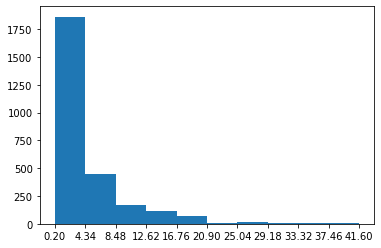

In [102]:
n, bins, _ = plt.hist(df_one_face_1967['percentage'], bins=10)
plt.xticks(bins)
plt.show()

## Фильм 1997 года

In [27]:
film_path_1997 = '/Users/tonleon/Desktop/Films/Anna_Karenina_1997.mkv'

In [28]:
extract_every_k_second_frame(film_path_1997, '1997_frames', 1)

done


I found 1 face(s) in this photograph.
A face is located at pixel location Top: 706, Left: 854, Bottom: 974, Right: 1122


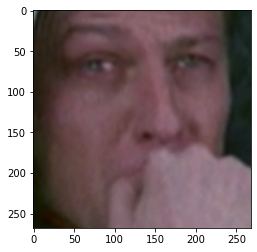

In [89]:
from PIL import Image
image = face_recognition.load_image_file("/Users/tonleon/Desktop/Снимок экрана 2021-02-07 в 23.55.12.png")
face_locations = face_recognition.face_locations(image)
print("I found {} face(s) in this photograph.".format(len(face_locations)))
for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

    # You can access the actual face itself like this:
    face_image = image[top:bottom, left:right]
    plt.imshow(face_image)
#     pil_image = Image.fromarray(face_image)
#     pil_image.show()

In [44]:
trial_data = create_df_with_frames_info('trial_frames')

In [45]:
trial_data

,frame_num,num_of_faces,profile_faces,frontal_faces,frontal_percentage,profile_percentage
0,207_frame.jpg,1,(),"[[407, 85, 273, 273]]",[11.0],[]
1,201_frame.jpg,0,(),(),[],[]
2,199_frame.jpg,0,(),(),[],[]
3,206_frame.jpg,1,(),"[[352, 104, 319, 319]]",[15.1],[]
4,195_frame.jpg,0,(),(),[],[]
5,200_frame.jpg,0,(),(),[],[]
6,198_frame.jpg,0,(),(),[],[]
7,208_frame.jpg,1,(),"[[346, 35, 243, 243]]",[8.7],[]
8,205_frame.jpg,0,(),(),[],[]
9,196_frame.jpg,0,(),(),[],[]


In [31]:
data_1997.to_csv('/Users/tonleon/Documents/GitHub/Diploma/Films/Data/All_Frames_1997.csv', header=True)

AttributeError: type object 'object' has no attribute 'dtype'

In [14]:
df_one_face_1997 = one_face_frames(data_1997)

In [15]:
df_one_face_1997['percentage'] = df_one_face_1997['percentage'].apply(lambda x: round(x[0], 1))

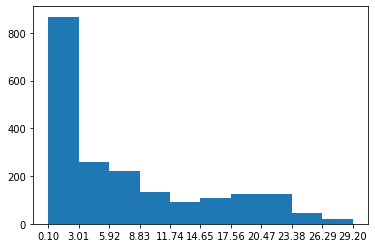

In [17]:
n, bins, _ = plt.hist(df_one_face_1997['percentage'], bins=10)
plt.xticks(bins)
plt.show()